# Measuring dissolved methane degradation based on tritium-marking
This notebook reproduces results and figures found in the manuscript. See manuscript for details on the model and discussion of results.

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import lmfit
import matplotlib.pyplot as plt
import corner
from numba import njit
import arviz as az
import seaborn as sns

In [2]:
#
# Model definition functions
#
@njit
def exponential_decay_with_background(t, C0, tau, cb, q):
    '''C(t) = C0 (e^{-ln(2) q t / tau} + cb)'''
    return (C0 - cb) * (1 - np.exp(-np.log(2) * q / tau * t)) + cb

def residual(pars, datasets):
    v = pars.valuesdict()
    residuals = []
    for ds_idx, (t, data) in datasets.items():
        qname = f'q{ds_idx}'
        cur_res = exponential_decay_with_background(t, v['C0'], v['tau'], v['cb'], v[qname])[:, None] - data
        residuals.append(cur_res.flatten())
        
    return np.concatenate(residuals).flatten()

In [3]:
#
# Data loading and cleaning function
#
DATA_FILE = '../data/labdata-tritium.xlsx'

def load_data():
    # Get data from experiment 1
    data1 = pd.read_excel(DATA_FILE, sheet_name='Sheet1', header=None).iloc[:, 1:].astype(float)
    data1.index = data1.index.astype(float)
    data1.index.values[:] = [1e3, 0, 4, 13, 17, 27]
    data1 = data1.sort_index()
    
    # Get data from experiment 2
    data2 = pd.read_excel(DATA_FILE, sheet_name='Sheet2', header=None).iloc[:, 1:].astype(float)
    data2.index = data2.index.astype(float)
    data2.index.values[:] = [1e3, 0, 2]
    data2 = data2.sort_index()

    # Get data from experiment 1b
    data3 = pd.read_excel(DATA_FILE, sheet_name='Sheet3', header=None).iloc[:, 1:].astype(float)
    data3.index = data3.index.astype(float)
    data3.index.values[:] = [0, 4]
    data3 = data3.sort_index()

    # Global normalization factor for data
    norm_factor = data1.iloc[0, :].dropna().mean()

    # Assemble datasets
    datasets = {1: (data1.index.values, data1.values/norm_factor), 
                2: (data2.index.values, data2.values/norm_factor),
                3: (data3.index.values, data3.values/norm_factor)}
    
    return datasets

In [4]:
#
# SETTINGS
#

# Define parameters with prior distributions (constraints)
fit_params = lmfit.create_params(C0=dict(value=2.5, min=0., vary=True),
                                 tau=dict(value=10, min=0.25, max=100, vary=True),
                                 q1=dict(value=1, min=0, vary=False),
                                 q2=dict(value=2**0.35, min=0, vary=False),
                                 q3=dict(value=1, min=0, vary=False),
                                 cb=dict(value=1., min=0, vary=True))

In [5]:
#
# Load datasets
#
datasets = load_data()

# Define time points to use for model evaluations and plotting
t = datasets[1][0]
tfine = np.linspace(t[0], min(4*t[-1], 100), 500)

datasets

{1: (array([   0.,    4.,   13.,   17.,   27., 1000.]),
  array([[0.83030322, 0.40931199, 0.97374382, 1.78664097],
         [2.24864666, 3.2226614 , 2.24009899, 2.34688411],
         [2.37549062, 3.10029585, 2.47248959, 3.74132723],
         [2.78357851, 1.72117883, 3.60007497, 2.11510168],
         [3.44229131,        nan,        nan,        nan],
         [4.50303232, 4.96269377, 3.05510265, 2.76376295]])),
 2: (array([   0.,    2., 1000.]),
  array([[0.14901152, 0.1483381 , 0.13593125,        nan],
         [1.01607748, 0.44089194, 1.3216939 , 1.16670786],
         [4.50303232, 4.96269377, 3.05510265, 2.76376295]])),
 3: (array([0., 4.]),
  array([[0.43199484, 0.15354853,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan],
         [0.19420804, 0.38338478, 0.29702341, 0.20203696, 0.16808953,
          0.48245156, 0.21238705, 0.28606513, 0.24741814]]))}

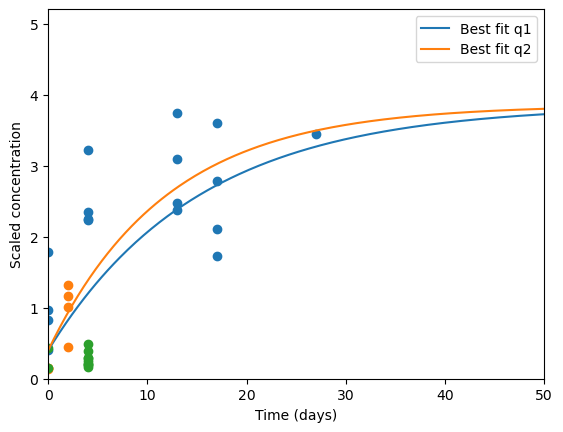

In [6]:
#
# Estimate model parameters from data - Nelder
#

# Fit model
out = lmfit.minimize(residual, fit_params, args=(), kws={'datasets': datasets}, nan_policy='omit', method='Nelder')

# Plot data
fig, ax = plt.subplots()
for c, (_, (t, d)) in zip(sns.color_palette(), datasets.items()):
    ax.plot(t, d, 'o', c=c)

# Plot result of fit
v = out.params.valuesdict()
ax.plot(tfine, exponential_decay_with_background(tfine, v['C0'], v['tau'], v['cb'], v['q1']), ls='-', label='Best fit q1')
ax.plot(tfine, exponential_decay_with_background(tfine, v['C0'], v['tau'], v['cb'], v['q2']), ls='-', label='Best fit q2')

# Labels, legends and axis stuff
ax.legend(loc='upper right')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Scaled concentration')
ax.set_ylim(bottom=0)
ax.set_xlim(0, 50)

plt.savefig('scaled-concentration-estimated-parameters-both-temps.png', dpi=200, bbox_inches='tight')

out

In [7]:
#
# Sample posterior with emcee
#
emcee_params = out.params.copy()
mini = lmfit.Minimizer(residual, nan_policy='omit', fcn_kws={'datasets': datasets}, params=emcee_params)
res = mini.emcee(progress='notebook',  burn=1000, steps=10000, thin=20, workers=1, is_weighted=False, float_behavior='chi2')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
res

In [9]:
res.flatchain.columns

Index(['C0', 'tau', 'cb', '__lnsigma'], dtype='object')

In [10]:
#
# Convert MCMC chain from emcee to ArviZ xarray dataset
#
name_map = {'C0': '$C_{tot}$', 'cb': '$C_b$', 'tau': '$t_{1/2}$', '__lnsigma': '$\\ln \\sigma$'}
var_names = [name_map[k] for k in res.flatchain.columns]
idata1 = az.from_emcee(mini.sampler, var_names=var_names)
idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Quantiles:
[(0.16, 0.23860967793872606), (0.5, 0.46258846430363376), (0.84, 0.6995159949187278)]
Quantiles:
[(0.16, 3.583554827343288), (0.5, 3.878492928784025), (0.84, 4.178591929078948)]
Quantiles:
[(0.16, -0.24243415010700403), (0.5, -0.13301948586489581), (0.84, -0.014680601445181591)]
Quantiles:
[(0.16, 8.93771327703961), (0.5, 11.63224896543947), (0.84, 15.577155463154204)]


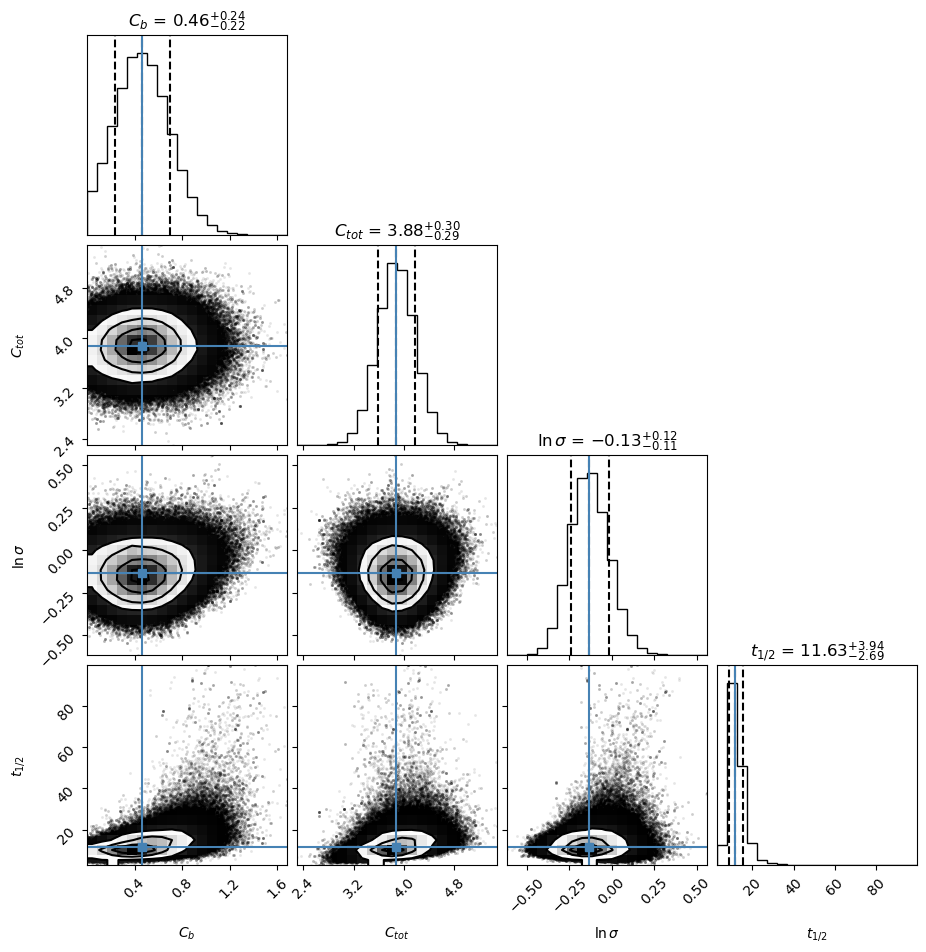

In [11]:
#
# Plot marginal posterior distributions 
#
inv_name_map = {'$C_{tot}$': 'C0', '$C_b$': 'cb', '$t_{1/2}$': 'tau', '$\\ln \\sigma$':'__lnsigma'}
emcee_plot = corner.corner(idata1, show_titles=True, verbose=True, plot_contours=True, quantiles=[0.16, 0.5, 0.84],
                          truths={name_map[p]: res.params[p].value for p in res.var_names},
                          titles=[p for p in idata1.posterior.data_vars.keys()])

plt.savefig('mcmc-corner-parameters.png', dpi=200, bbox_inches='tight')

/home/torn/Projects/Fate-of-methane/notebooks/best_fit_to_lab_data.pdf


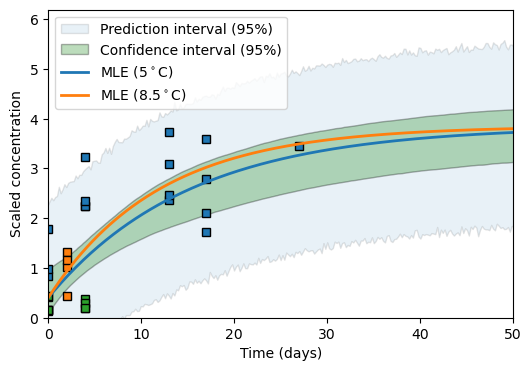

In [12]:
#
# Figure for manuscript - best fit with confidence and prediction intervals, based on the MCMC posterior
#

# Plot the observed data points
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for c, (_, (t, d)) in zip(sns.color_palette(), datasets.items()):
    ax.plot(t, d[:, :4], ls='none', c=c, marker='s', mec='k')

# Draw random samples from the posterior and calculate model and data realisations
inds = np.random.randint(len(res.flatchain), size=3000)
data_realisations = []
model_realisations = []
for ind in inds:
    v = res.flatchain.iloc[ind]
    model_realisation = exponential_decay_with_background(tfine, v['C0'], v['tau'], v['cb'], fit_params['q1'].value)
    data_realisation = np.random.normal(loc=model_realisation, scale=np.exp(v['__lnsigma']))
    data_realisations.append(data_realisation)
    model_realisations.append(model_realisation)
    
# Calculate and plot prediction interval for centered 95 percentile of the data realisations
ax.fill_between(tfine, *np.percentile(data_realisations, [2.5, 97.5], axis=0), ls='-', ec='k', alpha=0.1, label='Prediction interval (95%)')

# Calculate and plot CONFIDENCE interval for centered 95 percentile (ca 2 sigma) of the data realisations
ax.fill_between(tfine, *np.percentile(model_realisations, [2.5, 97.5], axis=0), fc='forestgreen', 
                ls='-', ec='k', alpha=0.3, label='Confidence interval (95%)')

# Plot the best fit model predictions
v = out.params.valuesdict()
ax.plot(tfine, exponential_decay_with_background(tfine, v['C0'], v['tau'], v['cb'], v['q1']), lw=2, label='MLE ($5^\\circ$C)')
ax.plot(tfine, exponential_decay_with_background(tfine, v['C0'], v['tau'], v['cb'], v['q2']), lw=2, label='MLE ($8.5^\\circ$C)')

ax.legend(loc='upper left')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Scaled concentration')
ax.set_ylim(bottom=0)
ax.set_xlim(0, 50)

figname = os.path.abspath('best_fit_to_lab_data.pdf')
print(figname)
plt.savefig(figname, dpi=200, bbox_inches='tight')

In [13]:
#
# Print MLE value and quantiles from the posterior for each parameter: 16, 50 and 84. Export to LaTeX table
#
df_results = pd.DataFrame(columns=['MLE value',  'Posterior median', 'MLE standard error', 'Posterior 16-percentile', 'Posterior 84-percentile'])

# Extract parameter values from the Nelder optimization (Maximum Likelihood Estimates, MLEs)
mle_params = {k: v for k, v in out.params.valuesdict().items() if out.params[k].vary}

for i, k in enumerate(mle_params.keys()):
    print(k, np.percentile(res.flatchain[k], [16., 50., 84]))
    df_results.loc[name_map[k]] = [mle_params[k], np.percentile(res.flatchain[k], 50), res.params[k].stderr, np.percentile(res.flatchain[k], 16), np.percentile(res.flatchain[k], 84)]

df_results.index.name = 'Parameter'

df_results = df_results.reset_index().style.format(decimal='.', thousands=' ', precision=3).hide(axis=0)
df_results = df_results.set_table_styles([
    {'selector': 'toprule', 'props': ':toprule;'},
    {'selector': 'midrule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':bottomrule;'},
], overwrite=False)

df_results.to_latex('parameter-estimation-results-table.tex')
df_results

C0 [3.58336244 3.87753369 4.17962479]
tau [ 8.93628521 11.65209564 15.56165194]
cb [0.23850637 0.46317599 0.70050767]


Parameter,MLE value,Posterior median,MLE standard error,Posterior 16-percentile,Posterior 84-percentile
$C_{tot}$,3.853,3.878,0.300,3.583,4.180
$t_{1/2}$,10.526,11.652,3.330,8.936,15.562
$C_b$,0.398,0.463,0.232,0.239,0.701


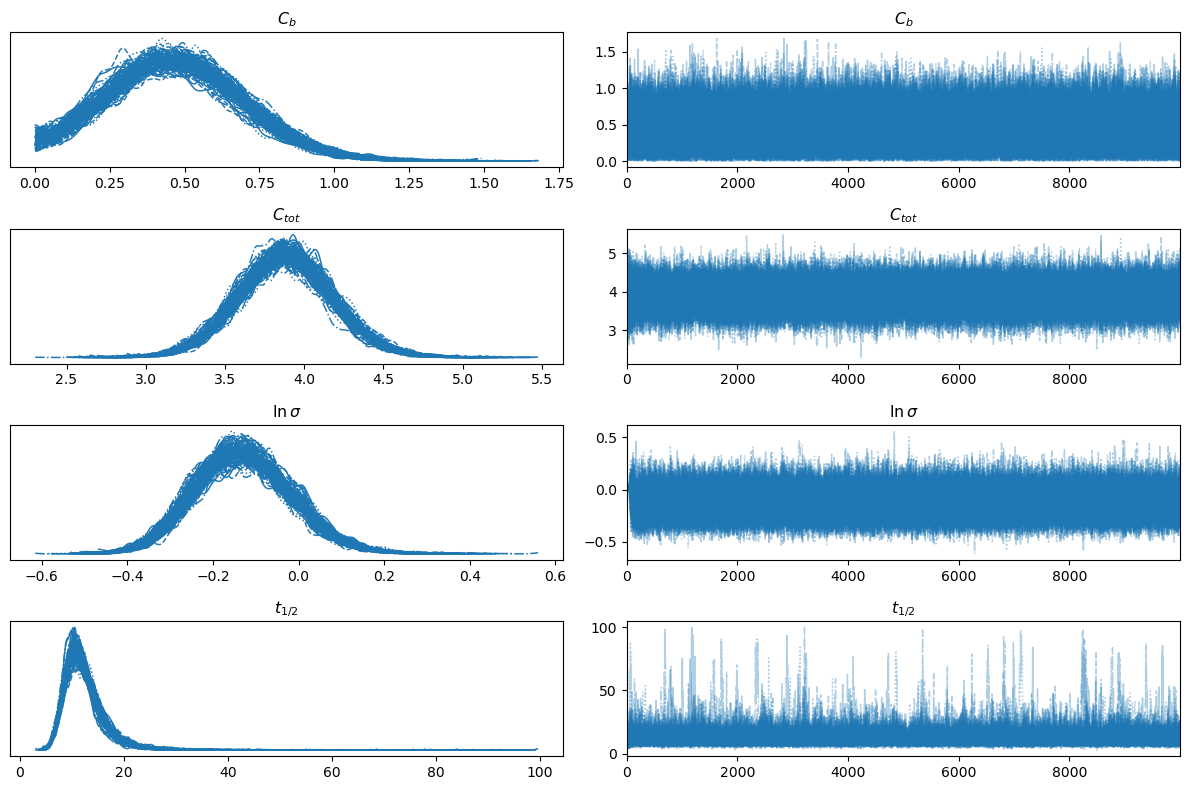

In [14]:
#
# Test ArviZ plotting
#
az.plot_trace(idata1)
plt.tight_layout()
plt.savefig('trace_plot.png', dpi=240)